In [1]:
# !mkdir -p data models
# !curl -L -o data/waste-classification-data-trainvaltest-short.zip\
#   https://www.kaggle.com/api/v1/datasets/download/stanislav9801/waste-classification-data-trainvaltest-short
# !unzip data/waste-classification-data-trainvaltest-short.zip -d data/
# !rm data/waste-classification-data-trainvaltest-short.zip

In [2]:
!pip install lightning -q

In [3]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.v2 as tfs
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

from lightning import LightningDataModule, LightningModule, Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch import seed_everything

In [4]:
@dataclass
class CFG:
    seed: int = 42
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    lr_fc: float = 1e-3
    batch_size: int = 128
    num_workers: int = 2
    # data_dir: str = 'data/DATASET'
    data_dir: str = '/kaggle/input/waste-classification-data-trainvaltest-short/DATASET'
    models_dir: str = 'models'
    unfreeze_epoch: int = 10
    lr_backbone: int = 1e-4

cfg = CFG()
seed_everything(cfg.seed)

INFO: Seed set to 42


42

In [5]:
def image_preview(img: np.ndarray):
    """Предпросмотр изображений
    """
    img_transpose = np.transpose(img, (1, 2, 0))
    # Нормализуем значения в диапазон от 0 до 255
    img_transpose_normalized = ((img_transpose - img_transpose.min()) / (img_transpose.max() - img_transpose.min()) * 255).astype(np.uint8)
    plt.imshow(img_transpose_normalized)

In [6]:
train_transforms = tfs.Compose([tfs.RandomRotation(30),
                                      tfs.RandomResizedCrop(224),
                                      tfs.RandomHorizontalFlip(),
                                      tfs.ToTensor(),
                                      tfs.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])
test_transforms = tfs.Compose([tfs.Resize(255),
                                     tfs.CenterCrop(224),
                                     tfs.ToTensor(),
                                     tfs.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [7]:
train_data = datasets.ImageFolder(cfg.data_dir+'/TRAIN', transform=train_transforms)
val_data = datasets.ImageFolder(cfg.data_dir+'/VAL', transform=test_transforms)
test_data = datasets.ImageFolder(cfg.data_dir+'/TEST', transform=test_transforms)

In [8]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=cfg.batch_size, num_workers=cfg.num_workers, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=cfg.batch_size, num_workers=cfg.num_workers, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=cfg.batch_size, num_workers=cfg.num_workers, pin_memory=True)

In [9]:
dataiter = iter(train_loader)
im, lab = next(dataiter)
im = im.numpy()

In [10]:
im.shape

(128, 3, 224, 224)

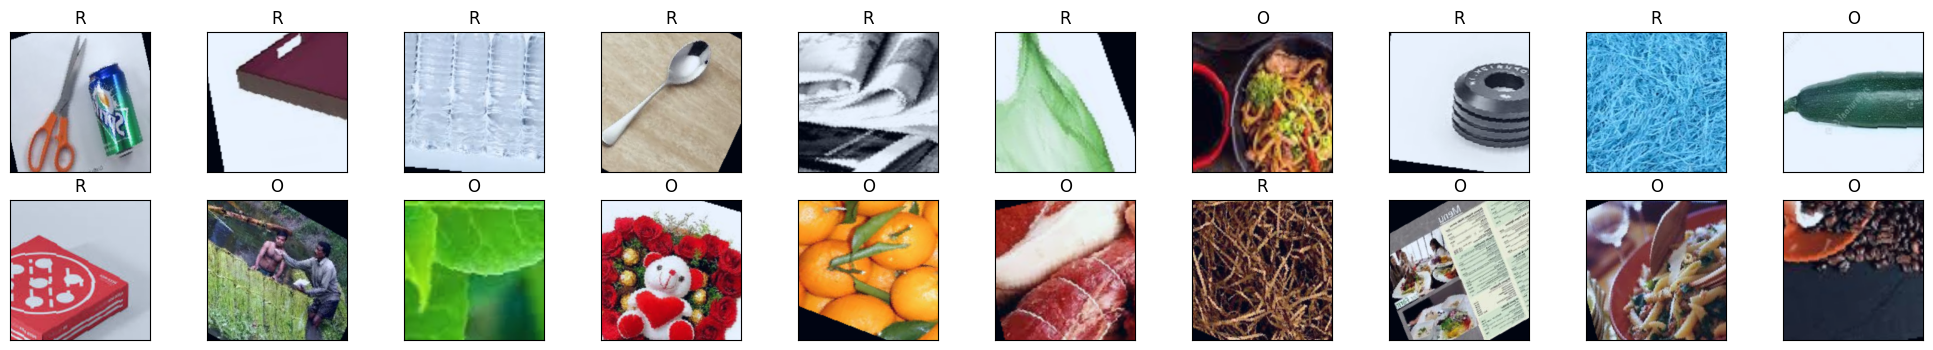

In [11]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    image_preview(im[idx])
    ax.set_title(train_data.classes[lab[idx]])

In [12]:
class WasteClassifierCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding='same')  #(B, 3, H, W) -> (B, 32, H, W)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same') #(B, 32, H, W) -> (B, 64, H, W)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding='same')

        self.dropout = nn.Dropout(.5)

        self.fc1 = nn.Linear(128*56*56, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        import pdb; pdb.set_trace()
        x = F.relu(self.conv1(x)) # (32, 224, 224)
        x = F.relu(self.conv2(x)) #(64, 224, 224)
        x = self.pool(x) #(64, 112, 112)

        x = F.relu(self.conv3(x)) #(128, 112, 112)
        x = F.relu(self.conv4(x)) #(128, 112, 112)
        x = self.pool(x) #(128, 56, 56)

        x = x.view(x.size(0), -1) #flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [13]:
class WasteLitModel(LightningModule):
    def __init__(self, unfreeze_epoch=3, lr_fc=1e-3, lr_backbone=1e-4):
        super().__init__()

        self.lr_fc = lr_fc
        self.lr_backbone = lr_backbone
        self.backbone_unfrozen = False  # чтобы не разморозить дважды
        self.unfreeze_epoch = unfreeze_epoch

        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        #self.model = torch.compile(model)
        for param in self.model.parameters():
          param.requires_grad = False

        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 2)
        for param in self.model.fc.parameters():
          param.requires_grad = True

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def basic_step(self, batch, batch_idx, stage):
        x, y = batch
        preds = self(x)
        loss = self.loss(preds, y)
        acc = (preds.argmax(dim=1) == y).float().mean()
        self.log(f"{stage}_loss", loss, prog_bar=True)
        self.log(f"{stage}_acc", acc, prog_bar=True)
        return loss

    def on_train_epoch_start(self):
        if (self.current_epoch == self.unfreeze_epoch) and not self.backbone_unfrozen:
          for param in self.model.parameters():
            param.requires_grad = True
          self.backbone_unfrozen = True

    def training_step(self, batch, batch_idx):
        return self.basic_step(batch, batch_idx, 'train')

    def validation_step(self, batch, batch_idx):
        return self.basic_step(batch, batch_idx, 'val')

    def test_step(self, batch, batch_idx):
        return self.basic_step(batch, batch_idx, 'test')

    def configure_optimizers(self):
        if not self.backbone_unfrozen:
          return optim.Adam(self.parameters(), lr=self.lr_fc)
        else:
          return optim.Adam([
              {"params": self.model.fc.parameters(), "lr": self.lr_fc},
              {"params": [p for n, p in self.model.named_parameters() if "fc" not in n], "lr": self.lr_backbone}
          ])


In [32]:
checkpoint_cb = ModelCheckpoint(
        monitor="val_acc",
        mode="max",
        save_top_k=2,
        filename="waste-resnet18-{epoch:02d}-{val_acc:.4f}",
        dirpath=cfg.models_dir
)
early_stop_cb = EarlyStopping(monitor='val_acc', mode='max', patience=3)

model = WasteLitModel(unfreeze_epoch=10, lr_fc=1e-3, lr_backbone=1e-4)
trainer = Trainer(
    max_epochs=10,
    precision='16-mixed',
    accelerator=cfg.device,
    callbacks=[
        checkpoint_cb,
        early_stop_cb,
        ],
    log_every_n_steps=3,
)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:701: Checkpoint directory /kaggle/working/models exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.
INFO: 
  | Name  | Type             | Params | Mode 
------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.


In [15]:
trainer.test(model, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.921999990940094     │
│         test_loss         │    0.20540954172611237    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.20540954172611237, 'test_acc': 0.921999990940094}]

In [16]:
!ls models/ | sort -t '=' -k 3 -n | tail -2

waste-resnet18-epoch=09-val_acc=0.9420-v1.ckpt
waste-resnet18-epoch=09-val_acc=0.9420-v2.ckpt


In [17]:
best_ckpt_path = checkpoint_cb.best_model_path
best_model = WasteLitModel.load_from_checkpoint(best_ckpt_path)
torch.save(best_model.model.state_dict(), "/kaggle/working/models/waste_resnet18_best.pth")

In [24]:
from pathlib import Path
from PIL import Image
import pandas as pd
class_names = ["O", "R"]
def load_model(weights_path="waste_resnet18_best.pth", device="cpu"):
    # Загружаем ResNet18 с 2 выходами
    model = models.resnet18(weights=None)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.eval()
    model.to(device)
    return model

def predict_image(img_path, model, device="cpu"):
    image = Image.open(img_path).convert("RGB")
    img_tensor = test_transforms(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(img_tensor)
        _, pred = torch.max(outputs, 1)
        class_name = class_names[pred.item()]
    return class_name

def predict_folder(folder_path, model, device="cpu", output_csv="predictions.csv"):
    folder = Path(folder_path)
    img_paths = list(folder.rglob("*.jpg"))

    results = []
    for img_path in img_paths:
        pred_class = predict_image(img_path, model, device)
        results.append({"image_path": str(img_path), "prediction": pred_class})

    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"✅ Предсказания сохранены в {output_csv}")
    
model = load_model('/kaggle/working/models/waste_resnet18_best.pth', device='cuda')
predict_folder(cfg.data_dir+'/TEST', model, output_csv='/kaggle/working/result.csv', device='cuda')

✅ Предсказания сохранены в /kaggle/working/result.csv
